In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

In [25]:
data_circuit1 = np.load('./Circuit1/spectrum-f_min_0-f_max_12501-f_step_250.npz')['arr_0']
data_circuit2 = np.load('./Circuit2/spectrum-f_min_0-f_max_12501-f_step_250.npz')['arr_0']

# Extract the first column (complex impedance)
impedance_circuit1 = data_circuit1[:, 0]
impedance_circuit2 = data_circuit2[:, 0]

# Separate into real and imaginary components
real_circuit1 = impedance_circuit1.real
imag_circuit1 = impedance_circuit1.imag

real_circuit2 = impedance_circuit2.real
imag_circuit2 = impedance_circuit2.imag

<Figure size 1000x500 with 0 Axes>

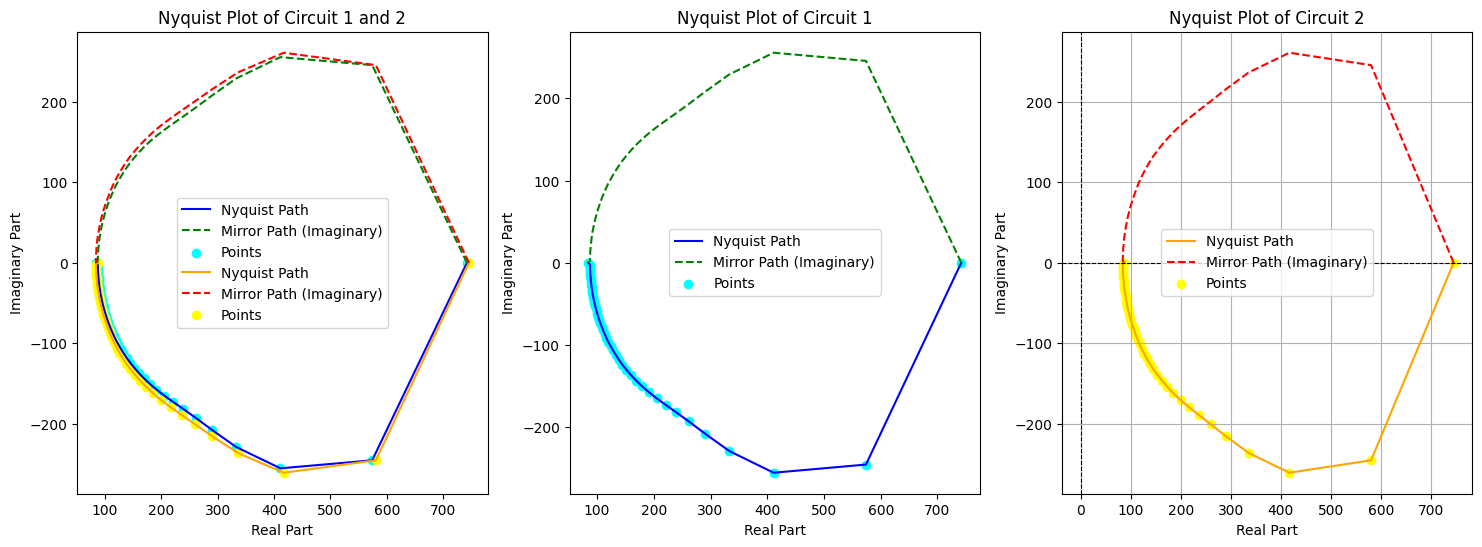

In [ ]:
# Plot Nyquist plots
plt.figure(figsize=(10, 5))

complex_values1 = real_circuit1 + 1j * imag_circuit1
complex_values2 = real_circuit2 + 1j * imag_circuit2

# Create Nyquist subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(complex_values1.real, complex_values1.imag, color="blue", label='Nyquist Path')
axs[0].plot(complex_values1.real, -complex_values1.imag, color="green", linestyle='--', label='Mirror Path (Imaginary)')
axs[0].scatter(complex_values1.real, complex_values1.imag, color='aqua', label='Points')  # Optional: Show discrete points

axs[0].plot(complex_values2.real, complex_values2.imag, color="orange", label='Nyquist Path')
axs[0].plot(complex_values2.real, -complex_values2.imag, color="red", linestyle='--', label='Mirror Path (Imaginary)')
axs[0].scatter(complex_values2.real, complex_values2.imag, color='yellow', label='Points')  # Optional: Show discrete points
axs[0].set_xlabel('Real Part')
axs[0].set_ylabel('Imaginary Part')
axs[0].set_title('Nyquist Plot of Circuit 1 and 2')
axs[0].legend()

axs[1].plot(complex_values1.real, complex_values1.imag, color="blue", label='Nyquist Path')
axs[1].plot(complex_values1.real, -complex_values1.imag, color="green", linestyle='--', label='Mirror Path (Imaginary)')
axs[1].scatter(complex_values1.real, complex_values1.imag, color='aqua', label='Points')  # Optional: Show discrete points
axs[1].set_xlabel('Real Part')
axs[1].set_ylabel('Imaginary Part')
axs[1].set_title('Nyquist Plot of Circuit 1')
axs[1].legend()

axs[2].plot(complex_values2.real, complex_values2.imag, color="orange", label='Nyquist Path')
axs[2].plot(complex_values2.real, -complex_values2.imag, color="red", linestyle='--', label='Mirror Path (Imaginary)')
axs[2].scatter(complex_values2.real, complex_values2.imag, color='yellow', label='Points')  # Optional: Show discrete points
axs[2].set_xlabel('Real Part')
axs[2].set_ylabel('Imaginary Part')
axs[2].set_title('Nyquist Plot of Circuit 2')
axs[2].legend()

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.grid()
plt.show()

#w=ct.tf()real_circuit1, imag_circuit1
#print(w)
#count, contour = ct.nyquist_plot(w, return_contour=True, arrows=2, arrow_size=8, start_marker=0, start_marker_size=12, linewidth=2)

# Circuit 1
#plt.plot(real_circuit1, -imag_circuit1, 'o-', label='Circuit 1')

# Circuit 2
#plt.plot(real_circuit2, -imag_circuit2, 's-', label='Circuit 2')

#plt.title("Nyquist Plot")
#plt.xlabel("Real Impedance (Ohms)")
#plt.ylabel("Imaginary Impedance (-Ohms)")
#plt.legend()
#plt.grid()
#plt.show()

In [27]:
# Define models for Circuit A and Circuit B
def model_circuit_a(frequencies, R, C):
    """Circuit A: R-C Parallel Model."""
    omega = 2 * np.pi * frequencies
    return R / (1 + 1j * omega * R * C)

def model_circuit_b(frequencies, R1, C1, R2, C2):
    """Circuit B: Double R-C Parallel Model."""
    omega = 2 * np.pi * frequencies
    Z1 = R1 / (1 + 1j * omega * R1 * C1)
    Z2 = R2 / (1 + 1j * omega * R2 * C2)
    return Z1 + Z2

# Define likelihood function
def log_likelihood(params, model, frequencies, real_data, imag_data):
    """Log-likelihood for Bayesian model fitting."""
    if model == "A":
        R, C = params
        predicted = model_circuit_a(frequencies, R, C)
    elif model == "B":
        R1, C1, R2, C2 = params
        predicted = model_circuit_b(frequencies, R1, C1, R2, C2)
    else:
        raise ValueError("Unknown model type")

    # Compute residuals
    residual_real = real_data - predicted.real
    residual_imag = imag_data - predicted.imag

    # Gaussian likelihood
    sigma = 1.0  # Assume measurement noise of 1 Ohm
    log_likelihood_real = np.sum(norm.logpdf(residual_real, scale=sigma))
    log_likelihood_imag = np.sum(norm.logpdf(residual_imag, scale=sigma))

    return log_likelihood_real + log_likelihood_imag

# Define Bayesian evidence calculation
def compute_bayesian_evidence(model, frequencies, real_data, imag_data, priors):
    """Compute Bayesian evidence for a model."""
    def negative_log_posterior(params):
        """Negative log posterior (likelihood + prior)."""
        log_prior = 0
        for p, (low, high) in zip(params, priors):
            if p < low or p > high:  # Uniform prior bounds
                return np.inf
            log_prior += np.log(1 / (high - low))
        log_likelihood_value = log_likelihood(params, model, frequencies, real_data, imag_data)
        return -(log_prior + log_likelihood_value)

    # Initial guess: midpoint of prior bounds
    initial_guess = [(low + high) / 2 for low, high in priors]

    # Minimize negative log posterior
    result = minimize(negative_log_posterior, initial_guess, method='L-BFGS-B')
    best_fit_params = result.x
    evidence = -result.fun  # Evidence is exp(-negative log posterior)
    return evidence, best_fit_params

In [28]:
# Define frequencies (example: linearly spaced from 1 Hz to 12.5 kHz)
frequencies = np.linspace(1, 12501, len(real_circuit1))

# Priors for Circuit A and B
priors_a = [(100, 10000), (1e-8, 1e-5)]  # R and C bounds
priors_b = [(100, 10000), (1e-8, 1e-5), (100, 10000), (1e-8, 1e-5)]  # R1, C1, R2, C2 bounds

# Compute evidence for Circuit A
evidence_a, params_a = compute_bayesian_evidence("A", frequencies, real_circuit1, imag_circuit1, priors_a)

# Compute evidence for Circuit B
evidence_b, params_b = compute_bayesian_evidence("B", frequencies, real_circuit1, imag_circuit1, priors_b)

# Print results
print("Circuit A Evidence:", evidence_a)
print("Circuit A Parameters:", params_a)

print("Circuit B Evidence:", evidence_b)
print("Circuit B Parameters:", params_b)

Circuit A Evidence: -9991618.697299384
Circuit A Parameters: [5.050e+03 5.005e-06]
Circuit B Evidence: -43588818.92818384
Circuit B Parameters: [5.050e+03 5.005e-06 5.050e+03 5.005e-06]


c:\Users\riann\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
